<a href="https://colab.research.google.com/github/hseguraq/Proyecto-Integrador-ITESM-MNAV/blob/main/S4_feature_eng_francisco_avances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ingeniería de Características**
# **Radiografías de Tórax**
## ITESM - MNA V

## Proyecto Integrador - TC5035.10

## Profesora: Dra. Grettel Barceló Alonso


### Equipo 19

Héctor Segura Quintanilla (A01154108)

Julio César García Escoto (A01795050)

Francisco Medellín Zertuche (A01794044)


In [ ]:
!pip install ImageHash

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from collections import Counter
from tqdm import tqdm

import cv2
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/Datos"
class_names = sorted(os.listdir(data_dir))
print("Clases encontradas:", class_names)

image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_file))
        labels.append(class_name)

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

Clases encontradas: ['ASD', 'Normal', 'PDA', 'VSD']


In [ ]:
# Mostrar las primeras 5 imagenes de cada clase
def show_sample_images_per_class(df, class_names, num_images=5):
  fig, axes = plt.subplots(len(class_names), 5, figsize=(15, 3*len(class_names)))

  for i, class_name in enumerate(class_names):
      class_imgs = df[df['label'] == class_name]['image_path'].head(5).values
      for j, img_path in enumerate(class_imgs):
          img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
          axes[i, j].imshow(img, cmap='gray')
          axes[i, j].axis('off')
          if j == 2:  # poner título en la imagen central de cada fila
              axes[i, j].set_title(class_name, fontsize=12)

  plt.tight_layout()
  plt.show()

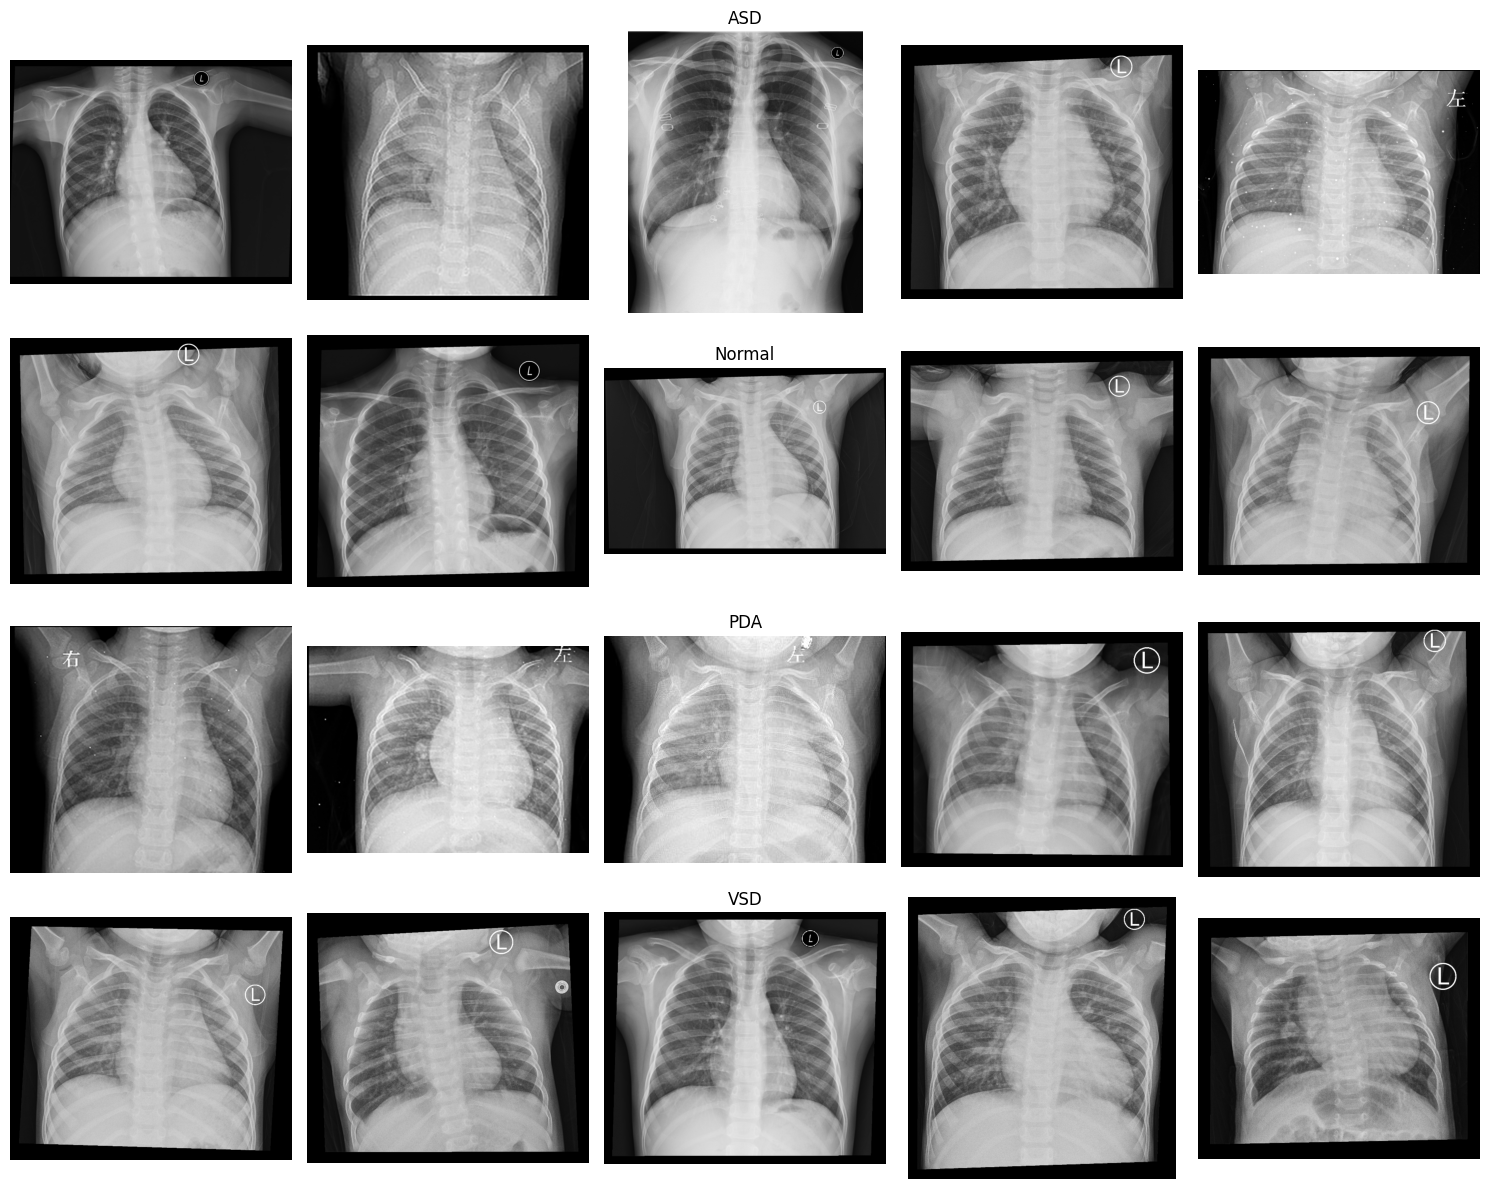

In [ ]:
show_sample_images_per_class(df, class_names, num_images=5)

## Héctor

1. Preprocesamiento de imágenes (Data Preparation)
Normalización de intensidades (ej. rescale [0,1], z-score).
* Alineación o centrado anatómico si aplica.
* Técnicas de reducción de ruido.
* Segmentación o recorte a regiones de interés (ROI).
* Generación de versiones estandarizadas (ej. redimensionado a 224×224).




## Héctor

2. Ingeniería de características (Feature Engineering)
* Transformaciones clásicas: extracción de bordes, filtros de textura, HOG, LBP.
* Características estadísticas: media, varianza, entropía de píxeles, etc.
* Métodos de reducción de dimensionalidad (PCA, t-SNE, UMAP para inspección).
* Comparación de representaciones crudas vs. representaciones profundas.

## Francisco

# 3. Generación de nuevas variables (Feature Construction)
* Combinación de características (ejemplo: cocientes de intensidades, índices de contraste).
* Features derivados de máscaras de segmentación (ejemplo: proporción área de pulmón/área total).
* Indicadores binarios (ejemplo: presencia/ausencia de ciertas estructuras).

### Calculo de Features de intensidad - pixeles
<BR>

Nuestro objetivo para la ceracion de los siguientes features es convertir cada imagen en un vector de estadísticas descriptivas que resumen la forma de la distribución de intensidades.

Los features y los gráficos generados muestran que hay diferencias notables entre las clases en cuanto a brillo, contraste y forma de la distribución de píxeles, lo que podria justificar un posible uso de estos features en tu modelo de clasificación.

Estos son features estadísticas útiles para clasificar imágenes, basados en pixeles.

- Primero nos aseguremos que los calculos sean en punto flotante, convirtiendo las imagenes a flotantes.

- Calculamos la intensidad promedio (pix_mean) mide brillo global de la imagen.

- Medimos el  contraste (pix_std: variación, qué tan dispersos están los valores de píxel).

- Calculamos si la distribución de intensidades está cargada hacia valores bajos (pix_skew: sesgo), (oscura) o altos (clara).

- Calculamos la curtosis para ver si la distribucion analizando la curva si esta en pico o plana, (imágenes con zonas muy uniformes vs. imágenes con muchos detalles).

- Percentiles (pix_p1, p5, p25, …), valores de intensidad en distintos puntos de la distribución para que nos den información robusta frente a outliers.

Estos features mencionados son para analizar la distribución de los valores de los píxeles de la imagen en un conjunto de descriptores numéricos.

In [ ]:
from scipy.stats import skew, kurtosis

def intensity_features(img):
    arr = img.astype(np.float32)   # convierte la imagen a flotantes
    feats = {}
    feats['pix_mean']  = float(arr.mean())                # media de intensidades
    feats['pix_std']   = float(arr.std())                 # desviación estándar
    feats['pix_skew']  = float(skew(arr.ravel()))         # asimetría (sesgo de la distribución)
    feats['pix_kurt']  = float(kurtosis(arr.ravel()))     # curtosis (forma de la distribución)
    # percentiles (cuantiles de intensidad)

    # percentiles
    for q in [1,5,25,50,75,95,99]:
        feats[f'pix_p{q}'] = float(np.percentile(arr, q))
    return feats

In [ ]:
all_features = []

for path in df['image_path']:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    feats = intensity_features(img)
    feats['image_path'] = path
    all_features.append(feats)

features_df = pd.DataFrame(all_features)

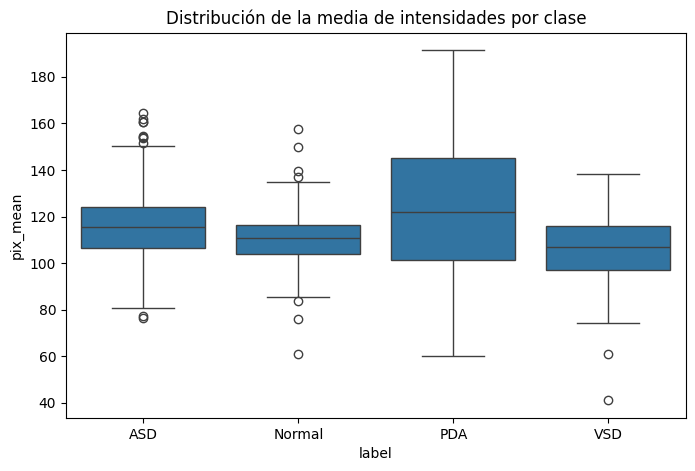

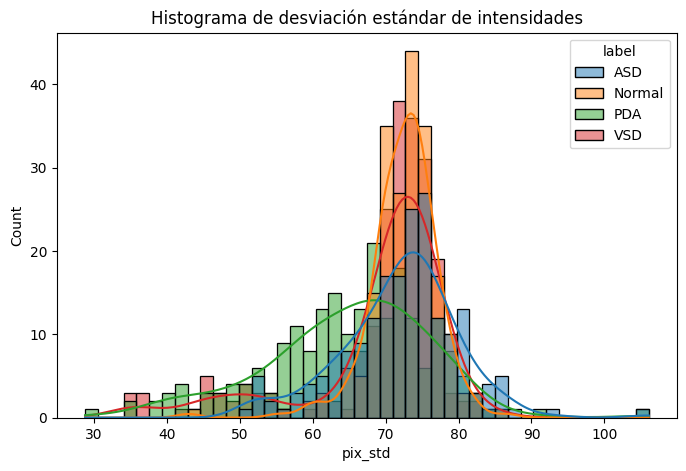

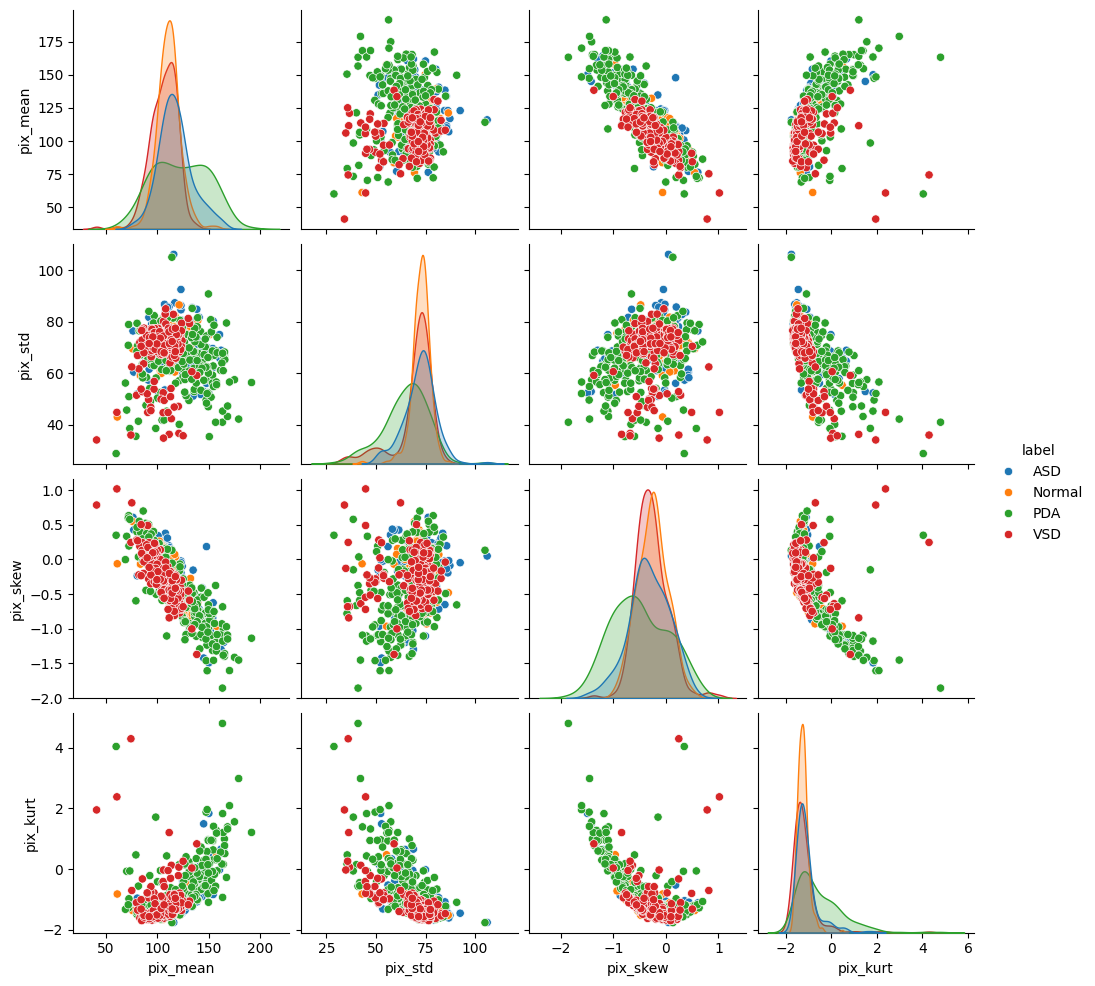

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Unir con las etiquetas
features_df = features_df.merge(df[['image_path','label']], on='image_path')

# Boxplot por clase para la media de intensidades
plt.figure(figsize=(8,5))
sns.boxplot(data=features_df, x='label', y='pix_mean')
plt.title("Distribución de la media de intensidades por clase")
plt.show()

# Histograma de la desviación estándar
plt.figure(figsize=(8,5))
sns.histplot(data=features_df, x='pix_std', hue='label', kde=True)
plt.title("Histograma de desviación estándar de intensidades")
plt.show()

# Pairplot para ver correlaciones
sns.pairplot(features_df[['pix_mean','pix_std','pix_skew','pix_kurt','label']], hue='label')
plt.show()

### Analisis de graficos

1. Bloxpot
- Vemos relaciones entre pix_mean, pix_std, pix_skew, pix_kurt.
- Se aprecian agrupaciones por clase: por ejemplo, PDA tiene valores de media y varianza más dispersos.
- Correlaciones claras: media vs. skew, media vs. kurt.
- Esto indica que las distribuciones de intensidad difieren entre clases, lo que puede ser útil para clasificación.

2. Histograma de desviación estándar <br>

- Cada clase tiene un rango característico de variabilidad en intensidades.
- Normal y ASD se concentran en desviaciones estándar alrededor de 70–75.
- PDA muestra mayor dispersión (más contrastes variados en sus imágenes).
- Esto confirma que el contraste promedio es diferente según la cardiopatía.


3. Boxplot de la media de intensidades <br>
- Las medias (pix_mean) varían por clase.
- PDA tiene distribuciones más amplias, mientras que ASD y Normal se concentran en valores más altos.
- Esto sugiere que el nivel de brillo promedio de las imágenes también es un factor discriminante.

## Francisco - Investigar si esto se puede hacer antes de la creacion de la red neuronal

4. Evaluación de la calidad de las características (Feature Evaluation)
* Métricas de separabilidad (ej. ANOVA F-score, mutual information entre características y etiquetas).
* Importancia de características en modelos de prueba rápida (árboles de decisión, random forest).
* Visualización en 2D de embeddings para verificar separabilidad entre clases.

5. Preparación de dataset final (Data Preparation for Modeling)
* Ensamblaje del conjunto de datos con las características seleccionadas.
* División en train/val/test.
* Guardado de los features en un formato reproducible (ej. CSV, parquet, HDF5).

6. Documentación y trazabilidad (Quality & Reproducibility)
* Registro de parámetros aplicados en cada paso.
* Versionado de datos procesados.
* Notas sobre decisiones tomadas y limitaciones observadas.